# Part 1: model definition

In [100]:
import pandas as pd
import requests
from pathlib import Path
from Bio import SeqIO
from Bio.Blast import NCBIXML
from Bio import AlignIO
from Bio import SearchIO
from Bio.SearchIO.HmmerIO import hmmer3_text
import scipy.stats
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

We start from the output of a BLAST search, using as seed sequence the domain sequence, against uniref50.

In [103]:
#Parse blast output
input_file = Path('Data/1_uniref_blast_hits.xml')

with open(input_file) as f:
  blast_records = NCBIXML.parse(f)
  data = []

  # Iterate PSIBLAST rounds (here just one since it is a simple BLAST)
  for blast_record in blast_records:
      query_id = blast_record.query

      # Iterate alignments
      for i, alignment in enumerate(blast_record.alignments):
          subject_id = alignment.title

          # Iterate pairwise alignments
          for hsp in alignment.hsps:
              data.append((query_id,
                              subject_id,
                              blast_record.query_length,
                              hsp.query,
                              hsp.match,
                              hsp.sbjct,
                              hsp.query_start,
                              hsp.query_end,
                              hsp.sbjct_start,
                              hsp.sbjct_end,
                              hsp.identities,
                              hsp.positives,
                              hsp.gaps,
                              hsp.expect,
                              hsp.score))

              # Skip duplicated subjects
              break

df = pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                  "query_seq", "match_seq", "subject_seq",
                                "query_start", "query_end", "subject_start", "subject_end",
                                "identity", "positive", "gaps", "eval", "bit_score"])
df.iloc[999]

query_id                                                EMBOSS_001
subject_id       UR50:UniRef50_A0A4W5JGG9 Integrin beta n=2 Tax...
query_len                                                      247
query_seq        PVDLYYLMDLSYSMKDDLERVRQLGHALLVRLQEVTHSVRIGFGSF...
match_seq        P+DLY LMD S SMKDDL+ ++++G  L   + +++    IGFG F...
subject_seq      PLDLYILMDFSNSMKDDLDNLKRMGAELAELVGKLSDDYTIGFGKF...
query_start                                                      5
query_end                                                       65
subject_start                                                  132
subject_end                                                    192
identity                                                        28
positive                                                        38
gaps                                                             0
eval                                                      0.000002
bit_score                                                    1

In [104]:
# Get Uniref50 accessions
out_file = 'Data/1_uniref_accessions.list'

with open(out_file, 'w') as fout:
  accessions = list(set([acc.split()[0].split(":")[1] for acc in df['subject_id']]))
  fout.write('\n'.join(accessions) + "\n")

- Accessions were used to retrieve Uniref50 sequences
- We then aligned them with ClustalOmega, and edited the alignment in Jalview by deleting rows with redundancy >= 95%, and deleting columns to the left and right of the most sonserved regions, going from around 7000 columns to around 250.
- We then generated the PSSM and HMM from the edited alignment, and used them to retrieve hits with PSI-Blast and HMMSEARCH against SwissProt

## Evaluate raw alignment

In [105]:
# let's look at entropy of the raw alignment
raw_seqs = []  # [[...], ...]
with open("Data/1_uniref_clustal_raw.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        raw_seqs.append(list(record.seq))
raw_seqs = np.array(raw_seqs, dtype="str")


In [106]:
aa = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
raw_data = []
for i, column in enumerate(raw_seqs.T):

    # count AA in column
    count = Counter(column)
    count.pop('-')
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    raw_data.append([i, occupancy, entropy, count_sorted])

raw_df = pd.DataFrame(raw_data, columns=['pos', 'occupancy', 'entropy', 'counts'])


<Axes: >

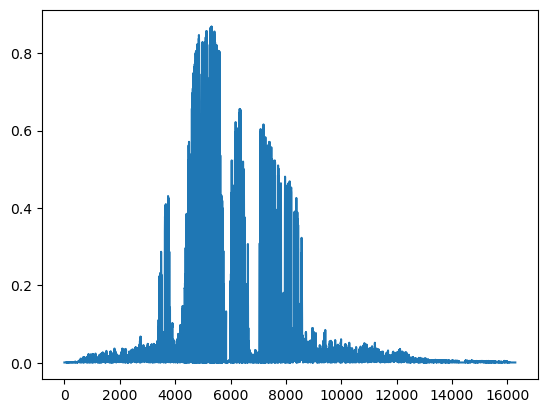

In [113]:
# Occupancy
raw_df['occupancy'].plot()

In [111]:
raw_entropy=raw_df['entropy'].tolist()
smoothed_entropy=[sum(raw_entropy[i:i+50])/50 for i in range(len(raw_entropy)-50)]

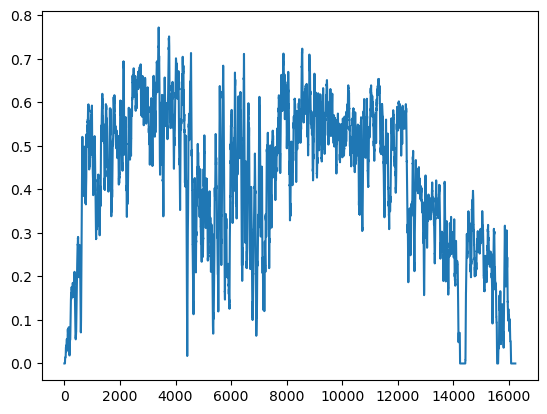

In [112]:
plt.plot(smoothed_entropy)

From these two plots, we can see that the most informative region is around 4000-6000 positions (high occupancy, lower entropy).
We look for a stretch of around 200-300 conserved positions in this regions, and trim to the left and right of it.

In [114]:
edited_seqs=[]
with open("Data/1_uniref_clustal_edited.fasta") as f:
    for record in AlignIO.read(f, "fasta"):
        edited_seqs.append(list(record.seq))
edited_seqs = np.array(edited_seqs, dtype="str")

In [115]:
edited_data = []
for i, column in enumerate(edited_seqs.T):

    # count AA in column
    count = Counter(column)
    try:
        count.pop('-')
    except:
        pass
    count_sorted = sorted(count.items(), key=lambda x:x[1], reverse=True)

    # count non gap AA
    non_gap = np.count_nonzero(column != "-")

    occupancy = non_gap / column.size

    # AA probability in column (gap excluded)
    # probabilities = [count.get(k, 0.0) / column.size for k in aa]
    probabilities = [count.get(k, 0.0) / non_gap for k in aa]

    # Zero entropy = complete conservation
    entropy = scipy.stats.entropy(probabilities, base=20)

    edited_data.append([i, occupancy, entropy, count_sorted])

edited_df = pd.DataFrame(edited_data, columns=['pos', 'occupancy', 'entropy', 'counts'])

<Axes: >

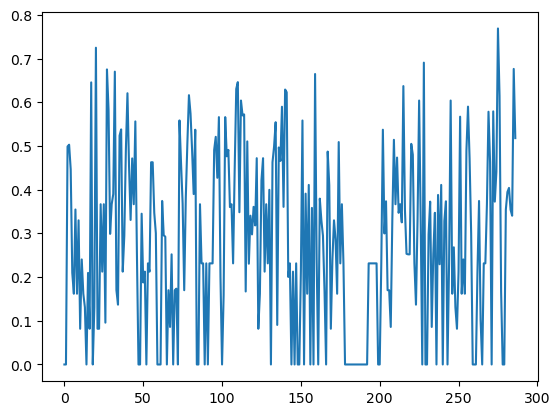

In [116]:
edited_df['entropy'].plot()

# Part 2: model evaluation

In [13]:
import requests
import json

## Collecting ground truth

In [44]:
# We use the interpro API to collect data on all swissprot entries with the assigned Pfam domain
accessions=[]
names=[]
length=[]
taxon=[]
start=[]
end=[]
URL="https://www.ebi.ac.uk:443/interpro/api/protein/reviewed/entry/pfam/PF00362/"
headers={'Content-Type':'application/json'}
r=requests.get(URL,headers=headers)
for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])
while r.json()['next']:
    URL=r.json()['next']
    r=requests.get(URL,headers=headers)
    for node in r.json()['results']:
        metadata=node['metadata']    
        entry=node['entries'][0]
        accessions.append(metadata['accession'])
        names.append(metadata['name'])
        length.append(metadata['length'])
        taxon.append(metadata['source_organism']['taxId'])
        start.append(entry['entry_protein_locations'][0]['fragments'][0]['start'])
        end.append(entry['entry_protein_locations'][0]['fragments'][0]['end'])

In [45]:
d={'accession':accessions,'name':names,'length':length,'taxon':taxon,'start':start,'end':end}
ground_truth=pd.DataFrame(data=d)

In [48]:
ground_truth.head()

,accession,name,length,taxon,start,end
0,A2A863,Integrin beta-4,1818,10090,128,370
1,A5Z1X6,Integrin beta-1,798,9837,138,382
2,B0FYY4,Integrin beta-1,798,9940,138,382
3,O54890,Integrin beta-3,787,10090,133,380
4,O70309,Integrin beta-5,798,10090,134,382


In [26]:
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

## Create confusion matrices

### Parse PSI-BLAST results

In [126]:
psiblast_hits=pd.read_csv('Data/2_uniref_pssm_hits.csv').iloc[:-1]
psiblast_hits.tail()

,Description(Sequences with E-value BETTER than threshold),Scientific Name,Max Score,Total Score,Query Cover,E value,Per. ident,Acc. Len,Accession
42,RecName: Full=Integrin beta-4; AltName: Full=G...,Rattus norvegicus,204,204,97%,1e-59,43.68,1807,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
43,RecName: Full=Integrin beta-4; AltName: CD_ant...,Mus musculus,203,203,97%,1e-59,43.68,1818,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
44,RecName: Full=Integrin beta-2-like protein; Al...,Mus musculus,143,143,99%,1e-38,36.51,738,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
45,RecName: Full=Integrin beta-2 [Xenopus laevis],Xenopus laevis,91.8,91.8,41%,2e-23,50.00,77,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."
46,RecName: Full=Alpha-protein kinase vwkA; AltNa...,Dictyostelium discoideum,45.2,45.2,83%,1e-04,22.16,625,"=HYPERLINK(""https://www.ncbi.nlm.nih.gov/prote..."


In [119]:
pssm_accessions=[]
pssm_positions=[]
with open('Data/2_uniref_pssm_aligns.fasta') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        res=record.id.split(':')
        pssm_accessions.append(res[0].split('.')[0])
        pssm_positions.append(res[1])

In [120]:
pssm_start=[]
pssm_end=[]
for interval in pssm_positions:
    start,end=interval.split('-')
    pssm_start.append(int(start))
    pssm_end.append(int(end))

In [127]:
pssm_evalue=psiblast_hits['E value'].tolist()
pssm_cover=psiblast_hits['Query Cover'].tolist()
pssm_identity=psiblast_hits['Per. ident'].tolist()
pssm_length=psiblast_hits['Acc. Len'].tolist()

In [128]:
pssm_data={'accession':pssm_accessions,'pred_start':pssm_start,'pred_end':pssm_end,'evalue':pssm_evalue,
           'cover':pssm_cover,'identity':pssm_identity,'length':pssm_length}

In [129]:
uniref_pssm_parsed_hits=pd.DataFrame(data=pssm_data)

In [130]:
uniref_pssm_parsed_hits.to_csv('Data/2_uniref_pssm_parsed_hits.csv')

### Parse hmmsearch results

In [166]:
# Dictionary with evalues
hmm_evalues={}
with open('Data/uniref_hmm_hittbl.txt') as handle:
    for result in SearchIO.parse(handle,'hmmer3-tab'):
        for hit in result.hits:
            hmm_accessions.append(hit.id.split('|')[1])
            hmm_evalues[hit.id.split('|')[1]]=hit.evalue

In [170]:
hmm_evalues

{'Q6AYF4': 1.9e-81,
 'Q9Z0T9': 2e-81,
 'P18564': 3.5e-81,
 'P80747': 3.9e-81,
 'O70309': 4.9e-81,
 'P05106': 5.5e-81,
 'P18563': 5.8e-81,
 'P18084': 8.4e-81,
 'Q1RPR6': 9.2e-81,
 'Q863C4': 1.4e-80,
 'Q8SQB8': 1.4e-80,
 'O54890': 1.1e-79,
 'P07228': 1.1e-79,
 'Q8R2H2': 1.3e-78,
 'P05556': 4.4e-78,
 'P09055': 6e-78,
 'P49134': 6.1e-78,
 'B0FYY4': 8e-78,
 'P53712': 1.1e-77,
 'P53713': 1.4e-77,
 'A5Z1X6': 1.4e-77,
 'P12606': 1.9e-77,
 'Q9GLP0': 2.8e-77,
 'P12607': 9.5e-77,
 'P26010': 5e-76,
 'Q5RCA9': 7.8e-76,
 'P26011': 2.4e-75,
 'Q5VI41': 2.5e-74,
 'P11835': 2.5e-74,
 'Q6ECI6': 3.1e-74,
 'Q2VJ42': 3.1e-74,
 'P05107': 7.9e-74,
 'P53714': 1e-73,
 'P32592': 1.2e-73,
 'P11584': 4.3e-73,
 'Q07441': 1.5e-71,
 'Q27874': 4.5e-68,
 'Q0VBD0': 2.4e-63,
 'P26012': 4e-63,
 'P26013': 9e-63,
 'Q27591': 1.8e-62,
 'A2A863': 2.4e-59,
 'Q64632': 3.3e-59,
 'P16144': 7.5e-59,
 'Q3UV74': 2e-34,
 'Q09062': 4.3e-19,
 'Q6B9X6': 0.02,
 'Q8C6K9': 0.059,
 'A6NMZ7': 0.28,
 'O00339': 0.3,
 'Q14587': 0.31,
 'P17032': 

In [171]:
# Create lists of hits' characteristics
hmm_taxon=[]
hmm_accession=[]
hmm_start=[]
hmm_end=[]
hmm_values=[]
with open('Data/uniref_hmm_aligns.txt') as handle:
    records=SeqIO.parse(handle,'stockholm')
    for record in records:
        taxon=record.description.split('=')[2].split(' ')[0]
        rec_id=record.id.split('|')
        accession=rec_id[1]
        start,end=rec_id[2].split('/')[1].split('-')
        if hmm_evalues[accession]<0.01:
            hmm_taxon.append(taxon)
            hmm_accession.append(accession)
            hmm_start.append(int(start))
            hmm_end.append(int(end))
            hmm_values.append(hmm_evalues[accession])       

In [172]:
# We're missing length
hmm_length=[]
URL='https://www.ebi.ac.uk/proteins/api'
headers={'Accept':'text/x-fasta'}
for accession in hmm_accession:
    r=requests.get(URL+'/proteins/'+accession,headers=headers)
    seq=r.text.split('\n')[1:]
    hmm_length.append(sum([len(piece) for piece in seq]))

In [173]:
hmm_data={'accession':hmm_accession,'pred_start':hmm_start,'pred_end':hmm_end,'taxon':hmm_taxon,'evalue':hmm_values
    ,'length':hmm_length}

In [174]:
uniref_hmm_parsed_hits=pd.DataFrame(data=hmm_data)

In [175]:
uniref_hmm_parsed_hits

,accession,pred_start,pred_end,taxon,evalue,length
0,Q6AYF4,129,317,10116,1.900000e-81,787
1,Q9Z0T9,129,317,10090,2.000000e-81,787
2,P18564,129,317,9606,3.500000e-81,788
3,P80747,134,323,9913,3.900000e-81,800
4,O70309,134,323,10090,4.900000e-81,798
5,P05106,134,322,9606,5.500000e-81,788
6,P18563,129,317,10141,5.800000e-81,788
7,P18084,134,323,9606,8.400000e-81,799
8,Q1RPR6,129,317,9823,9.200000e-81,788
9,Q863C4,129,317,9940,1.400000e-80,787


In [176]:
uniref_hmm_parsed_hits.to_csv('Data/2_uniref_hmm_parsed_hits.csv')

### Protein confusion matrix

In [177]:
ground_truth=pd.read_csv('Data/2_ground_truth.csv')
uniref_pssm_parsed_hits=pd.read_csv('Data/2_uniref_pssm_parsed_hits.csv')
uniref_hmm_parsed_hits=pd.read_csv('Data/2_uniref_hmm_parsed_hits.csv')
swissprot_IDs=pd.read_table('Data/swissprot_IDs.tsv',header=0)['Entry'].tolist()

#### PSSM

In [185]:
uniref_pssm_parsed_hits.iloc[-1]

Unnamed: 0        46
accession     Q6B9X6
pred_start       121
pred_end         254
evalue        0.0001
cover            83%
identity       22.16
length           625
Name: 46, dtype: object

In [82]:
predicted_accessions=uniref_pssm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [30]:
truth=[int(ID in true_accessions) for ID in swissprot_IDs]
pred=[int(ID in predicted_accessions) for ID in swissprot_IDs]
conf_matrix_pssm=confusion_matrix(truth,pred)

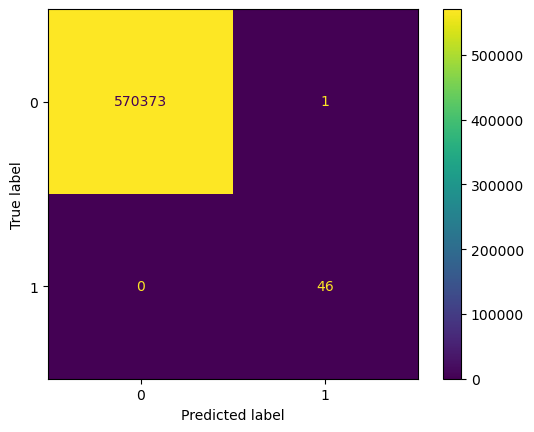

In [32]:
disp=ConfusionMatrixDisplay(conf_matrix_pssm)
disp.plot()

#### HMM

In [148]:
predicted_accessions=uniref_hmm_parsed_hits['accession'].tolist()
true_accessions=ground_truth['accession'].tolist()

In [149]:
predicted_accessions[-1]

'Q6B9X6'

In [150]:
truth=[int(ID in true_accessions) for ID in swissprot_IDs]
pred=[int(ID in predicted_accessions) for ID in swissprot_IDs]
conf_matrix_hmm=confusion_matrix(truth,pred)

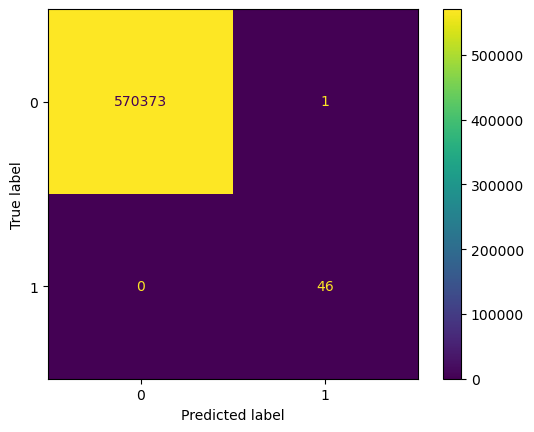

In [151]:
disp=ConfusionMatrixDisplay(conf_matrix_hmm)
disp.plot()

#### Discussion
In both models, we have a single false positive, corresponding to the accession Q6B9X6.
To choose the better model, we compare them at the residue level.

### Residue level results

#### PSSM

In [132]:
merged_data=ground_truth.merge(uniref_pssm_parsed_hits,on='accession',how='inner')

In [133]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_pssm_matrix=np.array([[tn,fp],[fn,tp]])

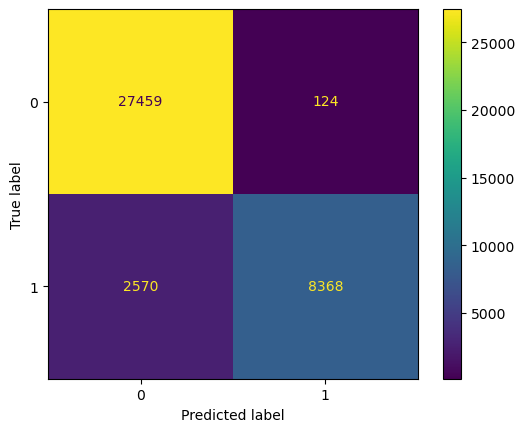

In [134]:
# Display confusion matrix
ConfusionMatrixDisplay(res_pssm_matrix).plot()

In [135]:
# Compute statistics
print('Precision:{}'.format(tp/(tp+fp)))
print('Recall:{}'.format(tp/(tp+fn)))
print('F-score:{}'.format(2*tp/(2*tp+fp+fn)))
print('Balanced accuracy:{}'.format(((tp/(tp+fn)+(tn/(tn+fp)))/2)))

Precision:0.9853980216674517
Recall:0.7650393124885719
F-score:0.8613484302624806
Balanced accuracy:0.8802718949420345


#### HMM

In [181]:
merged_data=ground_truth.merge(uniref_hmm_parsed_hits,on='accession',how='inner')

In [182]:
tp=0
fp=0
fn=0
tn=0
for index,row in merged_data.iterrows():
    start=row['start']
    end=row['end']
    pred_start=row['pred_start']
    pred_end=row['pred_end']
    length=row['length_x']
    for i in range(length):
        if start <= i <= end:
            if pred_start <= i <= pred_end:
                tp +=1
            else:
                fn += 1
        else:
            if pred_start <= i <= pred_end:
                fp += 1
            else:
                tn += 1
res_hmm_matrix=np.array([[tn,fp],[fn,tp]])

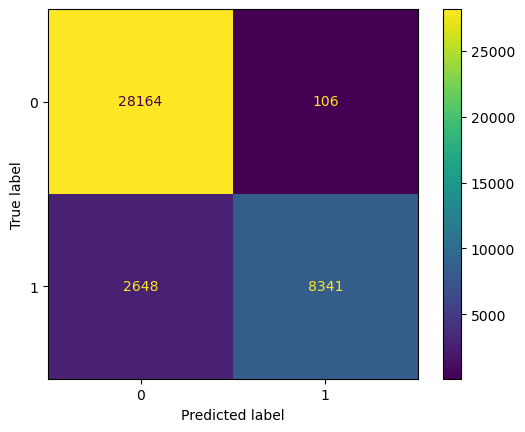

In [183]:
ConfusionMatrixDisplay(res_hmm_matrix).plot()

In [184]:
# Compute statistics
print('Precision:{}'.format(tp/(tp+fp)))
print('Recall:{}'.format(tp/(tp+fn)))
print('F-score:{}'.format(2*tp/(2*tp+fp+fn)))
print('Balanced accuracy:{}'.format(((tp/(tp+fn)+(tn/(tn+fp)))/2)))

Precision:0.9874511660944714
Recall:0.759031759031759
F-score:0.8583041778143651
Balanced accuracy:0.877641100598299


#### Discussion
The models perform very similarly and predict the same proteins.
For the next parts, it is indifferent which model we choose.
It is interesting to note that in both cases the only false positive in Uniprot accession Q6B9X6.

# Part 3: taxonomy